Run the timings and plot results

In [15]:
from typing import List, Dict, Any
import json
import functools

import matplotlib.pyplot as plt
import torch
import numpy as np

from mmv_timings import run_mmv_exp
from lauum_timings import run_lauum_exp
from potrf_timings import run_potrf_exp

import falkon
from falkon.kernels import GaussianKernel
from falkon.ooc_ops.ooc_potrf import gpu_cholesky
from scipy.linalg.lapack import spotrf, dpotrf

In [10]:
num_gpus = torch.cuda.device_count()
num_gpus

0

In [11]:
kernel = GaussianKernel(3.0)

## MMV Experiments

### Run the experiments

In [ ]:
Ns = [1_000, 5_000, 20_000, 50_000, 100_000, 200_000, 400_000, 600_000, 1_000_000, 2_000_000, 10_000_000]
Ds = [50, 100, 250, 1000, 2000, 3000, 5000, 7500, 10_000]
defaultM = 20_000
defaultN = 20_000
defaultT = 10
defaultD = 10

In [ ]:
experiments = [
    {
        'exp_name': 'varying N - KeOps 32',
        'changing_var': 'N',
        'data_sizes': {
            'N': Ns,
            'M': defaultM,
            'D': defaultD,
            'T': defaultT,
        },
        'kernel': kernel,
        'dtype': torch.float32,
        'num_reps': 10,
        'fn': 'kernel._keops_mmv_impl(X1, X2, v, kernel, out=None, opt=FalkonOptions(keops_active="force", compute_arch_speed=False));',
    },
    {
        'exp_name': 'varying N - Our 32',
        'changing_var': 'N',
        'data_sizes': {
            'N': Ns,
            'M': defaultM,
            'D': defaultD,
            'T': defaultT,
        },
        'kernel': kernel,
        'dtype': torch.float32,
        'num_reps': 10,
        'fn': 'kernel.mmv(X1, X2, v, out=None, opt=FalkonOptions(keops_active="no", compute_arch_speed=False));'
    },
    {
        'exp_name': 'varying D - KeOps 32',
        'changing_var': 'D',
        'data_sizes': {
            'N': defaultN,
            'M': defaultM,
            'D': Ds,
            'T': defaultT,
        },
        'kernel': kernel,
        'dtype': torch.float32,
        'num_reps': 10,
        'fn': 'kernel.keops_mmv_impl(X1, X2, v, kernel, out=None, opt=FalkonOptions(keops_active="force", compute_arch_speed=False));'
    },
    {
        'exp_name': 'varying D - Our 32',
        'changing_var': 'D',
        'data_sizes': {
            'N': defaultN,
            'M': defaultM,
            'D': Ds,
            'T': defaultT,
        },
        'kernel': kernel,
        'dtype': torch.float32,
        'num_reps': 10,
        'fn': 'kernel.mmv(X1, X2, v, out=None, opt=FalkonOptions(keops_active="no", compute_arch_speed=False));'
    },
]

In [ ]:
for exp in experiments:
    exp_times = run_mmv_exp(**exp)
    exp['timings'] = exp_times
    # Remove the stuff we can't serialize
    exp['kernel'] = None
    exp['dtype'] = None
with open("logs/mmv_timings_%dGPU.json" % (num_gpus), "w") as fh:
    json.dump(experiments, fh)

### Plot results

In [12]:
plot_gpus = 1

In [16]:
with open("logs/mmv_timings_%dGPU.json" % (plot_gpus), "r") as fh:
    experiments = json.load(fh)

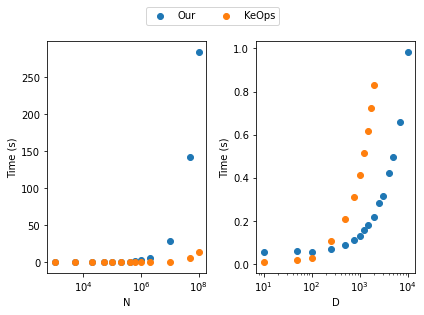

In [26]:
fig, axs = plt.subplots(ncols=2)

ax = axs[0]
n_keops = [e for e in experiments if e['exp_name'] == 'varying N - KeOps 32'][0]
n_our = [e for e in experiments if e['exp_name'] == 'varying N - Our 32'][0]

ax.scatter(n_our['data_sizes']['N'], n_our['timings'], label='Our')
ax.scatter(n_keops['data_sizes']['N'], n_keops['timings'], label='KeOps')

ax.set_xlabel('N')
ax.set_ylabel('Time (s)')
ax.set_xscale('log')

ax = axs[1]
n_keops = [e for e in experiments if e['exp_name'] == 'varying D - KeOps 32'][0]
n_our = [e for e in experiments if e['exp_name'] == 'varying D - Our 32'][0]

ax.scatter(n_our['data_sizes']['D'], n_our['timings'], label='Our')
ax.scatter(n_keops['data_sizes']['D'], n_keops['timings'], label='KeOps')

ax.set_xlabel('D')
ax.set_ylabel('Time (s)')
ax.set_xscale('log')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))

fig.tight_layout()

## POTRF


### Run Experiment


In [ ]:
defaultN32 = [10_000, 20_000, 30_000, 40_000, 50_000, 65_000, 80_000, 100_000, 120_000, 140_000]
defaultN64 = [10_000, 20_000, 30_000, 40_000, 50_000, 65_000, 80_000]
falkon.FalkonOptions(chol_force_ooc=True, chol_par_blk_multiplier=2, compute_arch_speed=False)

In [ ]:
potrf_exps: List[Dict[str, Any]] = [
    {
        'exp_name': 'Parallel 32',
        'exp_sizes': defaultN32,
        'dtype': np.float32,
        'num_reps': 3,
        'is_torch': True,
        'fn': functools.partial(
            gpu_cholesky, upper=False, clean=False, overwrite=True,
            opt=falkon.FalkonOptions(chol_force_ooc=True, chol_par_blk_multiplier=2)),
    },
    {
        'exp_name': 'Parallel 64',
        'exp_sizes': defaultN64,
        'dtype': np.float64,
        'num_reps': 3,
        'is_torch': True,
        'fn': functools.partial(
            gpu_cholesky, upper=False, clean=False, overwrite=True,
            opt=falkon.FalkonOptions(chol_force_ooc=True, chol_par_blk_multiplier=2,
                                     compute_arch_speed=False)),
    },
    {
        'exp_name': 'CPU 32',
        'exp_sizes': defaultN32,
        'dtype': np.float32,
        'num_reps': 3,
        'is_torch': False,
        'fn': functools.partial(spotrf, lower=True, clean=False, overwrite_a=True),
    },
    {
        'exp_name': 'CPU 64',
        'exp_sizes': defaultN64,
        'dtype': np.float64,
        'num_reps': 2,
        'is_torch': False,
        'fn': functools.partial(dpotrf, lower=True, clean=False, overwrite_a=True),
    },
]

In [ ]:
for exp in experiments:
    exp_times = run_potrf_exp(**exp)
    exp['timings'] = exp_times
with open("logs/potrf_timings_%dGPU.json" % (num_gpu), "w") as fh:
    json.dump(experiments, fh)
